<a href="https://colab.research.google.com/github/ghazaletlbn/my-bachelor-project/blob/main/bachelor_project_part_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import random
import scipy.sparse as sp
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.sparse.linalg import eigsh
from scipy.stats import pareto, expon, uniform, weibull_min
import math

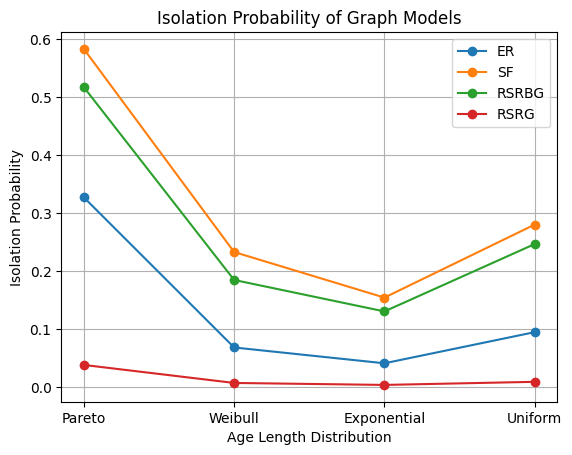

In [ ]:
def generate_random_bipartite_graph(d1, d2, n1, n2, num_edges):
    G = nx.Graph()

    # Create nodes in each partition
    nodes1 = list(range(n1))
    nodes2 = list(range(n1, n1 + n2))

    # Add nodes to the graph
    G.add_nodes_from(nodes1, bipartite=0)
    G.add_nodes_from(nodes2, bipartite=1)

    # Generate a list of all possible edges
    all_edges = [(u, v) for u in nodes1 for v in nodes2]

    # Randomly select edges until the desired number of edges is reached
    while G.number_of_edges() < num_edges:
        # Shuffle the list of possible edges
        random.shuffle(all_edges)

        for u, v in all_edges:
            if G.degree(u) < d1 and G.degree(v) < d2 and not G.has_edge(u, v):
                G.add_edge(u, v)
                break

    return G
def generate_rsrg_graph(n, p):
   # Create an initial complete graph with n nodes
    graph = [[1] * n for _ in range(n)]

    # Add new nodes iteratively
    for i in range(2, n + 1):
        new_node = [0] * i

        # Determine the number of connections for the new node
        num_connections = int(p * i)

        # Randomly select existing nodes to connect
        connected_nodes = random.sample(range(i - 1), num_connections)

        # Connect the new node to the selected existing nodes
        for node in connected_nodes:
            new_node[node] = 1
            graph[i-1][node] = 1

        # Append the new node to the graph
        graph.append(new_node)

    return graph


# Parameters
num_simulations = 200  # Number of simulations
num_nodes = 100  # Number of nodes in the graph
threshold_age = 80

# Age length distributions
age_distributions = {
    'Pareto': {'a': 3, 'b': 200},
    'Weibull': {'a': 0.5, 'b': -200},
    'Exponential': {'y': 0.01},
    'Uniform': {'low': 0, 'high': 200}
}

# Graph models
graph_models = {
    'ER': nx.gnp_random_graph,
    'SF': nx.scale_free_graph,
    'RSRBG': generate_random_bipartite_graph,
    'RSRG': generate_rsrg_graph
}

# Simulate and plot
for model_name, generate_graph in graph_models.items():
    isolation_probabilities = []
    for distribution_name, distribution_params in age_distributions.items():
        model_probs = []
        for _ in range(num_simulations):
            # Generate the graph
            if model_name == 'ER':
                p = 0.1  # Adjust the edge probability as desired
                graph = generate_graph(num_nodes, p)
            elif model_name == 'RSRBG':
                d1 = 5  # Degree in the first partition
                d2 = 5  # Degree in the second partition
                n1 = num_nodes // 2  # Number of nodes in the first partition
                n2 = num_nodes - n1  # Number of nodes in the second partition
                num_edges = num_nodes  # Number of edges to generate
                graph = generate_graph(d1, d2, n1, n2, num_edges)
            elif model_name == 'RSRG':
                p = 0.2  # Adjust the edge probability as desired
                rsrg_graph = generate_graph(num_nodes, p)
                # Convert the adjacency matrix to an edge list
                edges = []
                for i in range(len(rsrg_graph)):
                  for j in range(i + 1, len(rsrg_graph[i])):
                      if rsrg_graph[i][j] == 1:
                          edges.append((i, j))

                # Create a networkx graph from the edge list
                graph = nx.Graph()
                graph.add_edges_from(edges)
            else:
                graph = generate_graph(num_nodes)

            # Generate node ages based on the distribution
            ages = []
            if distribution_name == 'Pareto':
                ages = (1 - np.power(1 + np.random.uniform(size=num_nodes), -distribution_params['a'])) * distribution_params['b']
            elif distribution_name == 'Weibull':
                ages = -distribution_params['b'] * np.power(-np.log(np.random.uniform(size=num_nodes)), 1 / distribution_params['a'])
            elif distribution_name == 'Exponential':
                ages = -np.log(1 - np.random.uniform(size=num_nodes)) / distribution_params['y']
            elif distribution_name == 'Uniform':
                ages = np.random.uniform(low=distribution_params['low'], high=distribution_params['high'], size=num_nodes)

            # Calculate isolation probability
            num_isolated = 0
            for node in graph.nodes:
                neighbors = list(graph.neighbors(node))
                k = len(neighbors)
                if k > 0 and ages[node] > threshold_age:
                    r = random.randint(1, k)
                    if sum(ages[neighbor] > threshold_age for neighbor in random.sample(neighbors, r)) >= r:
                        num_isolated += 1
            model_probs.append(num_isolated / num_nodes)

        isolation_probabilities.append(np.mean(model_probs))

    # Plot
    plt.plot(list(age_distributions.keys()), isolation_probabilities, marker='o', label=model_name)

# Plot settings
plt.xlabel('Age Length Distribution')
plt.ylabel('Isolation Probability')
plt.legend(loc='upper right')
plt.title('Isolation Probability of Graph Models')
plt.grid(True)

# Show the plot
plt.show()


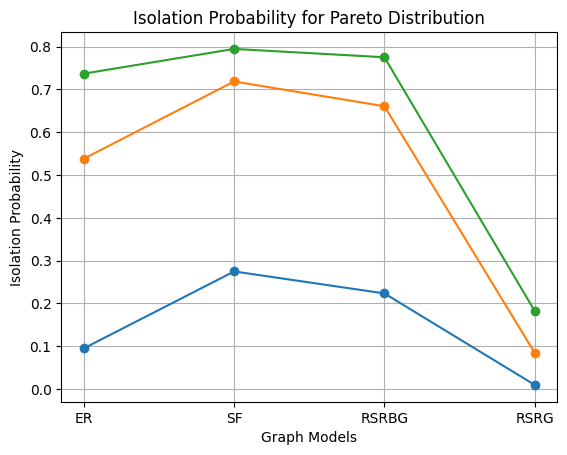

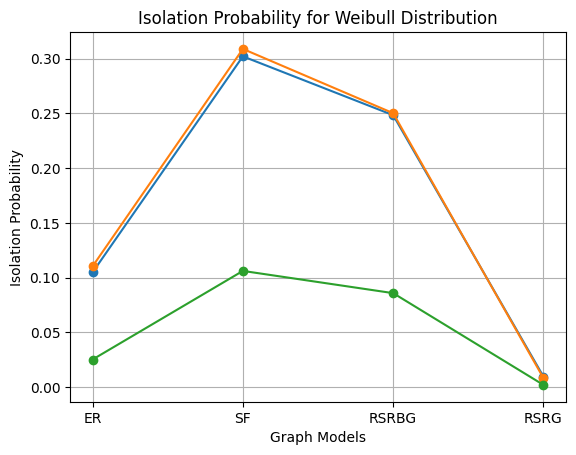

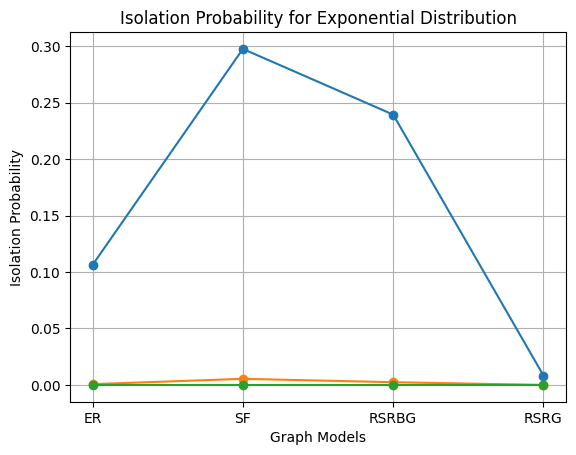

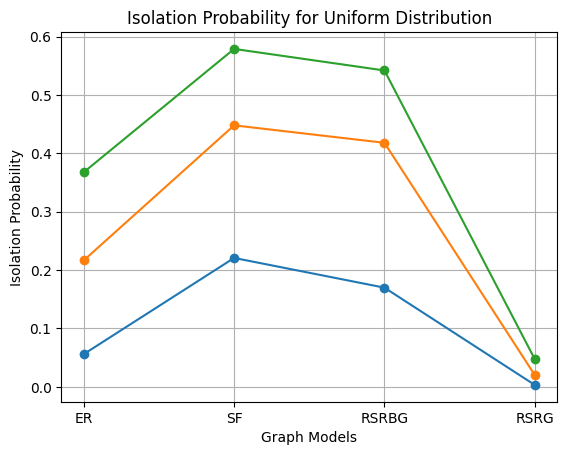

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# Parameters
num_simulations = 100  # Number of simulations
num_nodes = 100  # Number of nodes in the graph
threshold_age = 50

# Age length distributions
age_distributions = {
    'Pareto': [{'a': 2, 'b': 100}, {'a': 3, 'b': 200}, {'a': 4, 'b': 300}],
    'Weibull': [{'a': 0.5, 'b': -200}, {'a': 1, 'b': -100}, {'a': 2, 'b': -50}],
    'Exponential': [{'y': 0.01}, {'y': 0.05}, {'y': 0.1}],
    'Uniform': [{'low': 0, 'high': 100}, {'low': 0, 'high': 200}, {'low': 0, 'high': 300}]
}

# Graph models
graph_models = {
    'ER': nx.gnp_random_graph,
    'SF': nx.scale_free_graph,
    'RSRBG': generate_random_bipartite_graph,
    'RSRG': generate_rsrg_graph
}

# Simulate and plot
for distribution_name, distribution_param_list in age_distributions.items():
    for distribution_params in distribution_param_list:
        isolation_probabilities = []  # Initialize isolation probabilities for the current distribution parameters
        for model_name, generate_graph in graph_models.items():
            model_probs = []
            for _ in range(num_simulations):
                # Generate the graph
                if model_name == 'ER':
                    p = 0.1  # Adjust the edge probability as desired
                    graph = generate_graph(num_nodes, p)
                elif model_name == 'RSRBG':
                    d1 = 5  # Degree in the first partition
                    d2 = 5  # Degree in the second partition
                    n1 = num_nodes // 2  # Number of nodes in the first partition
                    n2 = num_nodes - n1  # Number of nodes in the second partition
                    num_edges = num_nodes  # Number of edges to generate
                    graph = generate_graph(d1, d2, n1, n2, num_edges)
                elif model_name == 'RSRG':
                    p = 0.2  # Adjust the edge probability as desired
                    rsrg_graph = generate_graph(num_nodes, p)
                    # Convert the adjacency matrix to an edge list
                    edges = []
                    for i in range(len(rsrg_graph)):
                        for j in range(i + 1, len(rsrg_graph[i])):
                            if rsrg_graph[i][j] == 1:
                                edges.append((i, j))

                    # Create a networkx graph from the edge list
                    graph = nx.Graph()
                    graph.add_edges_from(edges)
                else:
                    graph = generate_graph(num_nodes)

                # Generate node ages based on the distribution
                ages = []
                if distribution_name == 'Pareto':
                    ages = (1 - np.power(1 + np.random.uniform(size=num_nodes), -distribution_params['a'])) * \
                           distribution_params['b']
                elif distribution_name == 'Weibull':
                    ages = -distribution_params['b'] * np.power(-np.log(np.random.uniform(size=num_nodes)),
                                                                1 / distribution_params['a'])
                elif distribution_name == 'Exponential':
                    ages = -np.log(1 - np.random.uniform(size=num_nodes)) / distribution_params['y']
                elif distribution_name == 'Uniform':
                    ages = np.random.uniform(low=distribution_params['low'], high=distribution_params['high'],
                                             size=num_nodes)

                # Calculate isolation probability
                num_isolated = 0
                for node in graph.nodes:
                    neighbors = list(graph.neighbors(node))
                    k = len(neighbors)
                    if k > 0 and ages[node] > threshold_age:
                        r = random.randint(1, k)
                        if sum(ages[neighbor] > threshold_age for neighbor in random.sample(neighbors, r)) >= r:
                            num_isolated += 1
                model_probs.append(num_isolated / num_nodes)

            # Calculate the mean isolation probability for the current model
            isolation_probabilities.append(np.mean(model_probs))

        # Plot
        param_label = ', '.join([f'{key}={value}' for key, value in distribution_params.items()])
        plt.plot(list(graph_models.keys()), isolation_probabilities, marker='o', label=f'{model_name} ({param_label})')

    # Plot settings
    plt.xlabel('Graph Models')
    plt.ylabel('Isolation Probability')

    plt.title(f'Isolation Probability for {distribution_name} Distribution')
    plt.grid(True)

    # Show the plot
    plt.show()
